In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -U efficientnet

     |████████████████████████████████| 51kB 4.2MB/s 


In [4]:
import os
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import efficientnet.keras as efn

In [6]:
path = '/content/drive/My Drive/data/flowers/'

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE =128

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    seed=123,
    batch_size=BATCH_SIZE,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='categorical',
    seed=123,
    batch_size=BATCH_SIZE,
    subset='validation'
)

Found 3462 images belonging to 5 classes.
Found 861 images belonging to 5 classes.


(128, 224, 224, 3) (128, 5)


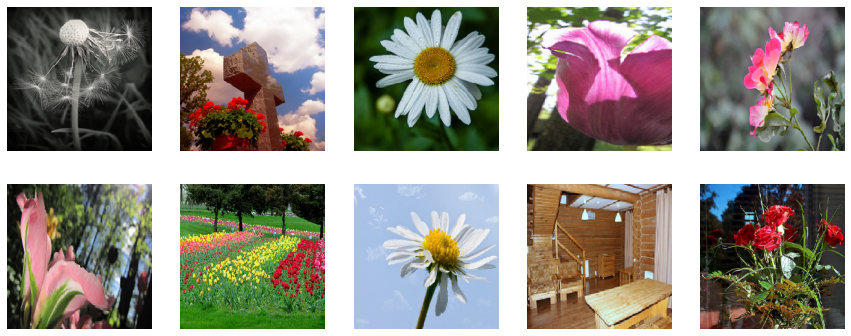

In [8]:
for x, y in train_generator:
    print(x.shape, y.shape)
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].axis('off')
    plt.show()
    break

In [9]:
efficientNet = efn.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = efficientNet.layers[-1].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(efficientNet.input, x)

for layer in model.layers[:-20]:
  layer.trainable = False
for layer in model.layers[-20:]:
  layer.trainable = True


model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
_____________________________

In [10]:
os.makedirs('models', exist_ok=True)
start_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

cp_earlystop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=5,
                             verbose=1)

cp_callback = ModelCheckpoint('models/%s-{epoch:02d}-{val_loss:.2f}.h5' % (start_time),
                              monitor='val_loss',
                              save_best_only=True,
                              mode='min', 
                              verbose=1)

In [11]:
history = model.fit(train_generator,
                    epochs = 10,
                    validation_data = validation_generator,
                    callbacks=[cp_earlystop, cp_callback])

Epoch 1/10
28/28 [==============================] - 1093s 38s/step - loss: 1.7066 - accuracy: 0.6154 - val_loss: 0.9673 - val_accuracy: 0.8537

Epoch 00001: val_loss improved from inf to 0.96730, saving model to models/2021-05-22_13-48-21-01-0.97.h5
Epoch 2/10
28/28 [==============================] - 17s 617ms/step - loss: 0.2084 - accuracy: 0.9228 - val_loss: 0.8068 - val_accuracy: 0.8699

Epoch 00002: val_loss improved from 0.96730 to 0.80682, saving model to models/2021-05-22_13-48-21-02-0.81.h5
Epoch 3/10
28/28 [==============================] - 17s 612ms/step - loss: 0.0945 - accuracy: 0.9664 - val_loss: 0.6993 - val_accuracy: 0.8734

Epoch 00003: val_loss improved from 0.80682 to 0.69934, saving model to models/2021-05-22_13-48-21-03-0.70.h5
Epoch 4/10
28/28 [==============================] - 17s 603ms/step - loss: 0.0561 - accuracy: 0.9850 - val_loss: 0.7683 - val_accuracy: 0.8827

Epoch 00004: val_loss did not improve from 0.69934
Epoch 5/10
28/28 [=============================

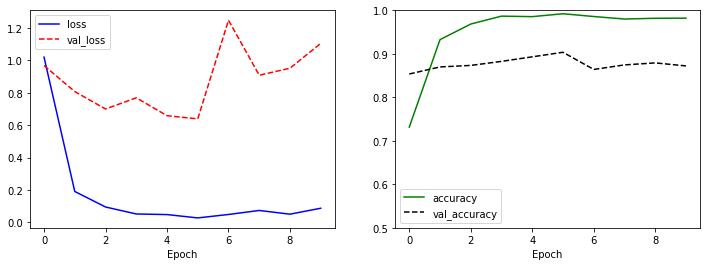

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.5, 1)
plt.legend()

plt.show()